# Toy example to test algorithms for fitting the Potts model with sampling 
The toy example has only 2 nodes (which are connected)
Each node can have four states, node one has $\pi_1=[0.6,0.05,0.01,0.2]$, 
for node 2 the probabilities are flat $\pi_2=0.25$.
Because the 2 nodes are connected with an edge, they will positively correlated when theta_w > 0 and negatively correlated when theta_w < 0
This also means that the marginal probabilities are not equal to the \pi parameters for each node.  

In [5]:
# Preliminaries 
import os
import sys 
sys.path.append(os.path.abspath('..'))
import emissions as em
from examples import simulate_potts_gauss_duo

### Example 1: independent nodes

U2   0.0   1.0   2.0   3.0
U1                        
0.0  9.0  17.0  16.0  10.0
1.0  NaN   1.0   2.0   1.0
2.0  9.0   5.0   4.0   4.0
3.0  4.0   6.0   5.0   7.0
U1
0.0    0.52
1.0    0.04
2.0    0.22
3.0    0.22
dtype: float64
U2
0.0    0.22
1.0    0.29
2.0    0.27
3.0    0.22
dtype: float64


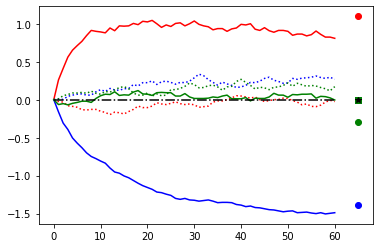

In [8]:

theta,i,thetaT=simulate_potts_gauss_duo(theta_w=0,sigma2 = 0.01,fit_theta_w=False)

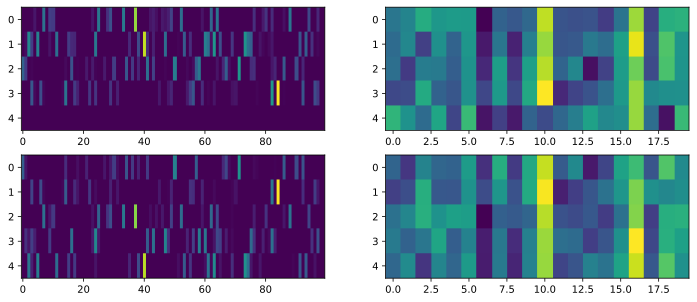

In [10]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.imshow(Uhat[1,:,:].T,aspect='auto')
plt.subplot(2,2,2)
plt.imshow(Vhat[1,:,:],aspect='auto')
plt.subplot(2,2,3)
plt.imshow(Uhat[0,:,:].T,aspect='auto')
plt.subplot(2,2,4)
plt.imshow(Vhat[0,:,:],aspect='auto')


In [6]:
vmatch=np.empty((num,num))
umatch=np.empty((num,num))
for i in range(num):
    for j in range(num):
        vmatch[i,j]=(Vhat[i,:,:] @ Vhat[j,:,:].T).max(axis=0).mean()
        umatch[i,j]=(Uhat[i,:,:].T @ Uhat[j,:,:]).max(axis=0).mean()
vmatch

array([[1.        , 0.57891748, 0.99999982, 0.9807568 , 0.98080068,
        0.99999981, 0.98075838, 0.99999992, 0.99999993, 0.99999979],
       [0.95832864, 1.        , 0.95834318, 0.95473639, 0.95472288,
        0.95834522, 0.95473552, 0.95836795, 0.95836188, 0.95834352],
       [0.99999982, 0.57887732, 1.        , 0.98083111, 0.98087488,
        1.        , 0.98083269, 0.99999967, 0.99999969, 1.        ],
       [0.9807568 , 0.58221233, 0.98083111, 1.        , 0.99999994,
        0.98083261, 1.        , 0.98071584, 0.98072067, 0.98083756],
       [0.98080068, 0.58219934, 0.98087488, 0.99999994, 1.        ,
        0.98087637, 0.99999994, 0.98075973, 0.98076455, 0.98088132],
       [0.99999981, 0.57887829, 1.        , 0.98083261, 0.98087637,
        1.        , 0.98083418, 0.99999967, 0.99999969, 1.        ],
       [0.98075838, 0.5822138 , 0.98083269, 1.        , 0.99999994,
        0.98083418, 1.        , 0.98071742, 0.98072224, 0.98083914],
       [0.99999992, 0.57892897, 0.9999996

## Now try the same on a hemisphere 

In [ ]:
# Load all surfaces 
flatsurf,inflsurf = load_surf()

In [ ]:
# Plot s02 task maps 
taskmap,colname,colmap = load_wcon('s02')

In [ ]:
# Load the task maps and center 
YL = np.vstack(taskmap[0].agg_data())
YR = np.vstack(taskmap[1].agg_data())
YL = YL-YL.mean(axis=0)
YR = YR-YR.mean(axis=0)
YL[np.isnan(YL)]=0
YR[np.isnan(YR)]=0

In [ ]:
snn1 = DictionaryLearning(n_components=10, transform_algorithm='lasso_cd',random_state=33,positive_code=True,fit_algorithm='cd',transform_max_iter=2000)
snn1.fit(YL.T)

In [ ]:
U = snn.transform(YL.T)
V = snn.components_

In [ ]:
a=plt.hist(np.sum(U,axis=1),bins=50)

In [ ]:
label = np.argmax(U,axis=1)
length = np.sum(U,axis=1)
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
ax2 = surf.plot.plotmap(label+1,flatsurf[0],overlay_type='label',cmap='Paired')
ax3 = plt.subplot(1,2,2)
ax4 = surf.plot.plotmap(np.sqrt(length),flatsurf[0],overlay_type='func')
plt.show()

In [ ]:
U1 = snn1.transform(YL.T)
V1 = snn1.components_
label = np.argmax(U1,axis=1)
length = np.sum(U1,axis=1)
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
ax2 = surf.plot.plotmap(label+1,flatsurf[0],overlay_type='label',cmap='Paired')
ax3 = plt.subplot(1,2,2)
ax4 = surf.plot.plotmap(np.sqrt(length),flatsurf[0],overlay_type='func')
plt.show()

In [ ]:
V- V1